In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import models,layers
from keras import Model
from keras.layers import concatenate
from keras.layers import Bidirectional, LSTM, Input, Dense
from keras.layers import Dropout
import math 
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import yfinance as yf
from sklearn.metrics import accuracy_score, mean_absolute_error
from math import sqrt
from keras.models import load_model
import yfinance as yf

2022-12-03 22:31:09.349713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 22:31:09.442538: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-03 22:31:09.442557: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-03 22:31:10.178190: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
meta = yf.download('META', start='2021-11-01', end='2022-11-01')
meta.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-01,326.040009,333.450012,326.000000,329.980011,329.980011,31518900
2021-11-02,331.380005,334.790009,323.799988,328.079987,328.079987,28353000
2021-11-03,327.489990,332.149994,323.200012,331.619995,331.619995,20786500
2021-11-04,334.010010,337.269989,332.649994,335.850006,335.850006,22495300
2021-11-05,340.309998,346.790009,339.640015,341.130005,341.130005,26872800


In [3]:
meta = meta.drop(['Adj Close','High','Low','Close','Volume'],axis=1)

In [4]:
meta_senti = pd.read_csv('../Sentiment Scores/META_news_sentiment.csv')
meta_senti.head()


,Unnamed: 0.1,Unnamed: 0,Date,Ticker,Url,headline,source,snippet,sentiment_score
0,0,0,4 days ago,META,https://www.nasdaq.com/articles/3-ultra-popula...,3 Ultra-Popular Stocks Billionaires Have Been ...,Nasdaq,"Randi Zuckerberg, a former director of market ...",0.000
1,1,1,3 weeks ago,META,https://abc7news.com/tech-layoff-tracker-bay-a...,"Meta, Twitter, Lyft, Netflix: We're tracking m...",ABC7 News,"Facebook parent Meta is laying off 11,000 peop...",0.000
2,2,2,05-Aug-22,META,https://inc42.com/buzz/meta-shut-down-facebook...,Meta To Shut Down Facebook Live Shopping From ...,Inc42,"“From 1 October 2022, you will no longer be ab...",-0.296
3,3,3,2 weeks ago,META,https://www.livehindustan.com/business/story-s...,फेसबुक वाले जुकरबर्ग के चेहरे पर लौट रही मुस्क...,Hindustan,साल की शुरुआत में कभी टॉप-10 में अमीरों में शु...,0.000
4,4,4,01-Oct-22,META,https://inc42.com/buzz/meta-actioned-23-78-mn-...,Meta Actioned 23.78 Mn Content Pieces Across F...,Inc42,Meta Actioned 23.78 Mn Content Pieces Across F...,0.000


In [5]:
meta_senti = meta_senti.drop(['Unnamed: 0','Unnamed: 0.1','Date','Ticker','Url','headline','source','snippet'],axis=1)


In [6]:
# remove 0s from sentiment
meta_senti = meta_senti[meta_senti['sentiment_score'] != 0]
meta_senti = meta_senti.append(pd.DataFrame(np.zeros((36,1)),columns=['sentiment_score']),ignore_index=True) 
# add random noise to last 36 row to avoid 0s
print(meta_senti.shape)
for i in range(36):
    meta_senti['sentiment_score'][meta_senti.shape[0]-i-1] = np.random.normal(0,0.1)
meta_senti.shape

(252, 1)


/tmp/ipykernel_11780/139637029.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meta_senti = meta_senti.append(pd.DataFrame(np.zeros((36,1)),columns=['sentiment_score']),ignore_index=True)


(252, 1)

In [7]:
meta_senti.head()

,sentiment_score
0,-0.2960
1,0.5994
2,0.0772
3,0.2960
4,0.2960


In [8]:
# combine the two dataframes
meta_senti['Date'] = meta.index
meta_senti = meta_senti.set_index('Date')
meta_senti 

,sentiment_score
Date,
2021-11-01,-0.296000
2021-11-02,0.599400
2021-11-03,0.077200
2021-11-04,0.296000
2021-11-05,0.296000
...,...
2022-10-25,0.090761
2022-10-26,0.135813
2022-10-27,-0.001347


In [9]:
# combine the two dataframes
meta = meta.join(meta_senti)
meta 

,Open,sentiment_score
Date,,
2021-11-01,326.040009,-0.296000
2021-11-02,331.380005,0.599400
2021-11-03,327.489990,0.077200
2021-11-04,334.010010,0.296000
2021-11-05,340.309998,0.296000
...,...,...
2022-10-25,130.880005,0.090761
2022-10-26,131.679993,0.135813
2022-10-27,97.980003,-0.001347


In [10]:
meta['Open'] = meta['Open'].interpolate(method = 'quadratic')
meta_new = meta.dropna()
meta_new

,Open,sentiment_score
Date,,
2021-11-01,326.040009,-0.296000
2021-11-02,331.380005,0.599400
2021-11-03,327.489990,0.077200
2021-11-04,334.010010,0.296000
2021-11-05,340.309998,0.296000
...,...,...
2022-10-25,130.880005,0.090761
2022-10-26,131.679993,0.135813
2022-10-27,97.980003,-0.001347


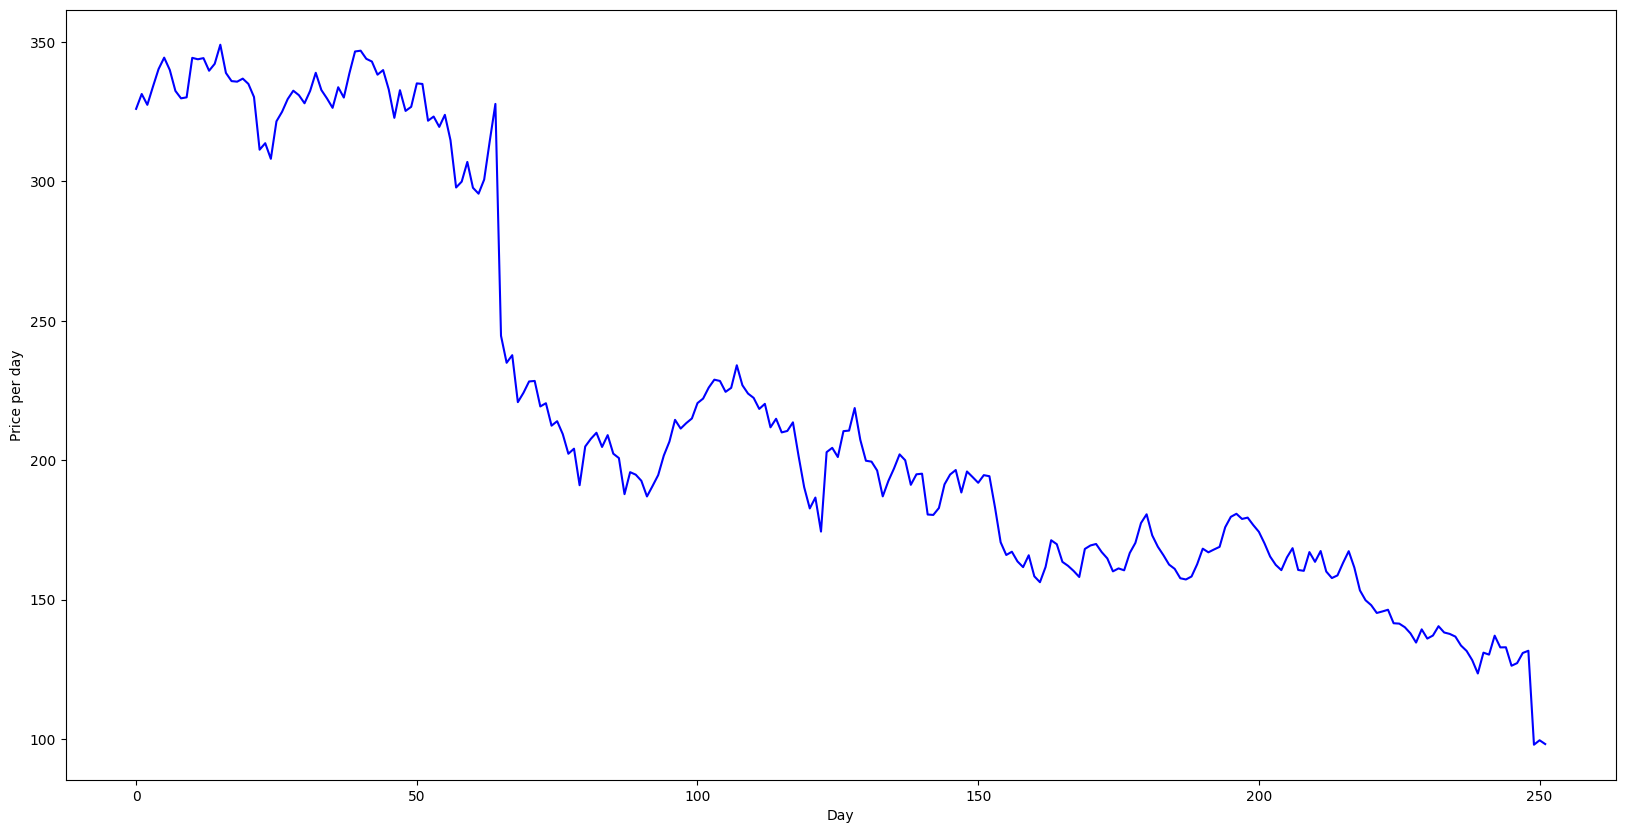

In [11]:
def time_series(x_axis,y_axis,x_label):
    plt.figure(figsize=(20,10))
    plt.plot(x_axis,y_axis,color = 'blue')
    plt.xlabel(x_label)
    plt.ylabel('Price per day')
    plt.show()
meta_data = meta_new.copy()
time_series(list(range(len(meta))),meta_data['Open'],'Day')

In [12]:
train_size = int(len(meta_data) * 0.8)
train_main= meta_new.iloc[:train_size]
test_main=meta_new.iloc[train_size:] 

In [13]:
cnt=MinMaxScaler()
cnt_transformer=cnt.fit(train_main[['Open']])
train_scaled=cnt_transformer.transform(train_main[['Open']])
test_scaled=cnt_transformer.transform(test_main[['Open']])

In [14]:
def dataset(Y, time_steps):
  x=[]
  y=[]
  for i in range(len(Y)-time_steps):
    v=Y[i:(i+time_steps)]
    u=Y[i+time_steps]
    x.append(v)
    y.append(u)
  return np.array(x),np.array(y)

In [15]:
TRAIN_X_val,TRAIN_Y=dataset(train_scaled,time_steps=5)
TEST_X_val,TEST_Y=dataset(test_scaled,time_steps=5)

In [16]:
model=models.Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(5, 1)))
#model.add(Dropout(0.2))
#model.add(Bidirectional(LSTM(128, return_sequences=True)))
#model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128)))
model.add(layers.Dense(1))
model.summary()

2022-12-03 22:31:12.170718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 22:31:12.170926: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-03 22:31:12.170980: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-03 22:31:12.171027: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-03 22:31:12.171073: W tensorflow/c

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 256)           133120    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 527,617
Trainable params: 527,617
Non-trainable params: 0
_________________________________________________________________


In [17]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model_checkpoint = ModelCheckpoint('timeseriesmodel.hdf5',
                                   monitor='val_mae',
                                   verbose=1,
                                   save_best_only=True,
                                   mode='min')
model.compile(loss='mae',optimizer=optimizer, metrics=['mse','mae'])

In [18]:

history=model.fit(TRAIN_X_val,TRAIN_Y,epochs=40, batch_size=10,validation_split=0.1,shuffle=True )

Epoch 1/40
18/18 [==============================] - 6s 76ms/step - loss: 0.1465 - mse: 0.0594 - mae: 0.1465 - val_loss: 0.0361 - val_mse: 0.0020 - val_mae: 0.0361
Epoch 2/40
18/18 [==============================] - 0s 15ms/step - loss: 0.0652 - mse: 0.0083 - mae: 0.0652 - val_loss: 0.0443 - val_mse: 0.0029 - val_mae: 0.0443
Epoch 3/40
18/18 [==============================] - 0s 16ms/step - loss: 0.0697 - mse: 0.0082 - mae: 0.0697 - val_loss: 0.0308 - val_mse: 0.0015 - val_mae: 0.0308
Epoch 4/40
18/18 [==============================] - 0s 15ms/step - loss: 0.0518 - mse: 0.0051 - mae: 0.0518 - val_loss: 0.0351 - val_mse: 0.0018 - val_mae: 0.0351
Epoch 5/40
18/18 [==============================] - 0s 15ms/step - loss: 0.0583 - mse: 0.0061 - mae: 0.0583 - val_loss: 0.0284 - val_mse: 0.0012 - val_mae: 0.0284
Epoch 6/40
18/18 [==============================] - 0s 16ms/step - loss: 0.0481 - mse: 0.0043 - mae: 0.0481 - val_loss: 0.0292 - val_mse: 0.0011 - val_mae: 0.0292
Epoch 7/40
18/18 [====

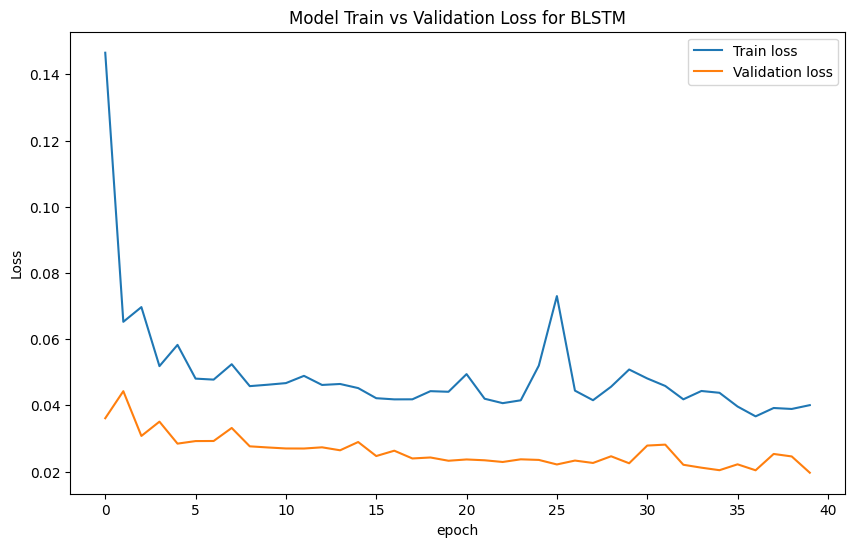

In [19]:
plt.figure(figsize = (10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train vs Validation Loss for BLSTM')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')

2/2 [==============================] - 1s 5ms/step


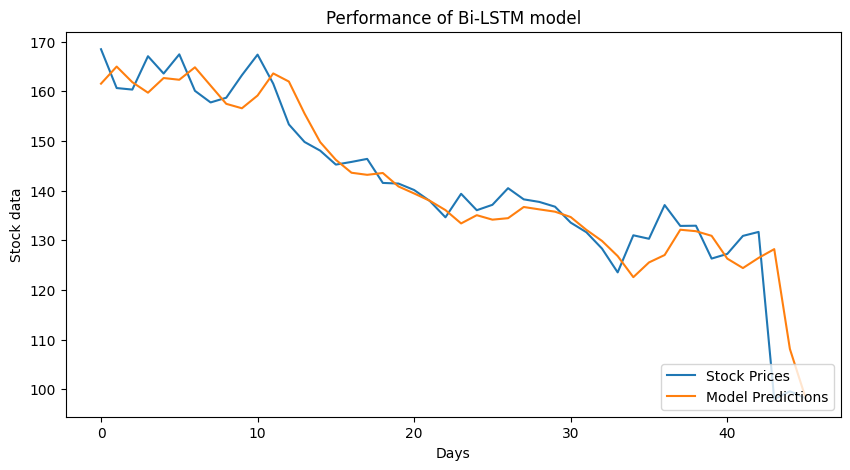

In [20]:
#model = load_model('timeseriesmodel.hdf5')
prediction = model.predict(TEST_X_val)
#prediction = cnt_transformer.inverse_transform(prediction)
range_future = len(prediction)
plt.figure(figsize=(10,5))
plt.plot(np.arange(range_future), cnt_transformer.inverse_transform(np.array(TEST_Y)),label='Test data')
plt.plot(np.arange(range_future), cnt_transformer.inverse_transform(np.array(prediction)),label='Prediction')
plt.legend(['Stock Prices', 'Model Predictions'], loc='lower right')
plt.xlabel('Days')
plt.ylabel('Stock data')
plt.title('Performance of Bi-LSTM model')
plt.show()

In [22]:
a = np.array(cnt_transformer.inverse_transform(np.array(TEST_Y)))
b = np.array(cnt_transformer.inverse_transform(np.array(prediction))).flatten()
print("For Bi-LSTM model:")
print("Accuracy : ", np.isclose(a, b, atol=36).mean() * 100, "%")
print("Mean Absolute Error: ", np.mean(np.abs(a - b)))

For Bi-LSTM model:
Accuracy :  89.65028355387523 %
Mean Absolute Error:  18.17380680884666
